## Fake News Binary Classification Problem

In [2]:
# import libraries

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [3]:
# specify the configuration of the Spark application

conf = SparkConf().set("spark.ui.port", "4050").set('spark.executor.memory', '4G').set('spark.driver.memory', '45G').set('spark.driver.maxResultSize', '10G')


#### Create spark session


In [4]:
import os
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
spark = SparkSession.builder.getOrCreate()

In [5]:
spark

#### Dataset Exploration

In [6]:
# Read the dataset 

news_df = spark.read.csv(path="news.csv",
                         sep=",",
                         inferSchema="true",
                         header="true")


In [7]:
# Types of the features of the dataframe

news_df.printSchema()

root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)
 |-- label: string (nullable = true)



In [8]:
# Shape of the dataset

print("The shape of the dataset is {:d} rows by {:d} columns".format(news_df.count(), len(news_df.columns)))


The shape of the dataset is 44906 rows by 5 columns


In [9]:
# Display values of the target

news_df.select("label").show(100)

+--------------------+
|               label|
+--------------------+
|                   1|
|               2017"|
|                   0|
|                   1|
|                   0|
|                   1|
|                   1|
|                   0|
|                   1|
|                   0|
|                   1|
|                   0|
|                   1|
|                   1|
|                   1|
|                   0|
|                   1|
|                   0|
|                   0|
|                   1|
|                   1|
|                   0|
|                   0|
|                   0|
|                   0|
|                   0|
|                   0|
|                   1|
|                   1|
|                   0|
|                   1|
|                   1|
|                   0|
|                   1|
|                   0|
|                   1|
|                   0|
|                   0|
|                   0|
|                   0|
|          

In [10]:
# Remove unimportant rows of the df

news_df = news_df.filter((news_df.label == 1) | (news_df.label == 0))

In [11]:
# Displaying the shape of the df after removing unnecessary rows

news_df.count()

43638

In [12]:
# show  first rows of the dataframe

news_df.show(n=15)

+--------------------+--------------------+---------------+-------------------+-----+
|               title|                text|        subject|               date|label|
+--------------------+--------------------+---------------+-------------------+-----+
| What Beyoncé Jus...|While so many kee...|           News|  February 22, 2016|    1|
|Lavrov: U.S. pres...|MOSCOW (Reuters) ...|      worldnews|  December 7, 2017 |    0|
|ILLEGAL ALIEN ARR...|Since when did fu...|      left-news|        Jul 8, 2015|    1|
|McConnell rules o...|WASHINGTON (Reute...|   politicsNews|    March 20, 2016 |    0|
|MUSLIM ACTIVISTS ...|Who would ve gues...|Government News|       Dec 23, 2015|    1|
|BREAKING: #Crooke...|She s the most cr...|      left-news|       Aug 30, 2016|    1|
|France's Macron i...|PARIS (Reuters) -...|      worldnews| November 15, 2017 |    0|
| Two Unarmed Secu...|Sometime around 2...|           News|      July 17, 2016|    1|
|Bill proposes let...|WASHINGTON (Reute...|   politics

In [13]:
# Convert string data type into integer type

news_df = news_df.withColumn("label", news_df.label.cast('int'))


In [14]:
news_df.select("label").dtypes

[('label', 'int')]

In [15]:
# import libraries for text cleaning

from pyspark.sql.functions import isnan, when, count, col

In [16]:
# Cheking for null values

news_df.select([count(when(isnan(col), col)).alias(col) for col in news_df.columns]).show()


+-----+----+-------+----+-----+
|title|text|subject|date|label|
+-----+----+-------+----+-----+
|    0|   0|      0|   0|    0|
+-----+----+-------+----+-----+



In [17]:
# Removing unimportant features 

news_df = news_df.drop("subject","date", "title")

In [18]:
news_df.columns

['text', 'label']

In [19]:
#show the independent feature of the dataframe

news_df.select("label").show(n=10)

+-----+
|label|
+-----+
|    1|
|    0|
|    1|
|    0|
|    1|
|    1|
|    0|
|    1|
|    0|
|    1|
+-----+
only showing top 10 rows



In [20]:
# check if the dataset is imbalanced

major_df = news_df.filter(col("label") == 1)
minor_df = news_df.filter(col("label") == 0)

In [21]:
ratio = (major_df.count()/minor_df.count())

In [22]:
# ratio between minority and majority class

print("ratio: {}".format(ratio)) 

ratio: 1.0464265616207091


In [23]:
# majority class

print(f"Class 1:{major_df.count()/news_df.count() * 100} ")


Class 1:51.13433246253265 


In [24]:
# minority class

print(f"Class 0: {minor_df.count()/news_df.count() * 100} ")


Class 0: 48.865667537467345 


In [25]:
# visualize label 

visualize_label = news_df.select("label").toPandas()

<AxesSubplot:xlabel='label', ylabel='count'>

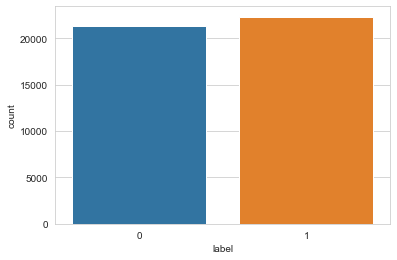

In [26]:
sns.set_style('whitegrid')
sns.countplot(x='label',data=visualize_label)

In [27]:
# Print the number of duplicated news in the dataframe

print("The total number of duplicated news are {:d} out of {:d}".
      format(news_df.count() - news_df.dropDuplicates(['text']).count(), news_df.count()))

The total number of duplicated news are 5989 out of 43638


In [28]:
# Dropping duplicated news from "text" feature

news_df = news_df.dropDuplicates(["text"])

In [29]:
news_df.count()

37649

In [30]:
print("The total number of unique news in our dataset is: {:d}".format(news_df.count()))

The total number of unique news in our dataset is: 37649


### Text Preprocessing phase

    1.  Text cleaning 
    2.  Tokenization 
    3.  Stopwards removal
    4.  Stemming 

In [31]:
from pyspark.sql.functions import udf, col, lower, trim, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem.snowball import SnowballStemmer

In [32]:
def text_preprocessing(df, column_name="content"):
   
    # Text Cleaning
    lower_case_news_df = df.withColumn(column_name, lower(col(column_name)))

    # Trimming the text
    trimmed_news_df = lower_case_news_df.withColumn(column_name, trim(col(column_name)))

    # Filtering out punctuations in the text
    no_punct_news_df = trimmed_news_df.withColumn(column_name, (regexp_replace(col(column_name), "[^a-zA-Z\\s]", "")))

    # Removing any extra whitespaces
    cleaned_news_df = no_punct_news_df.withColumn(column_name, trim(regexp_replace(col(column_name), " +", " ")))

    # Splitting text into tokens
    tokenizer = Tokenizer(inputCol=column_name, outputCol="tokens")
    tokens_df = tokenizer.transform(cleaned_news_df)

    # Removing Stopwords
    stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="terms")
    terms_df = stopwords_remover.transform(tokens_df)
   
    # Stemming words
    stemmer = SnowballStemmer(language="english")
    stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
    terms_stemmed_df = terms_df.withColumn("terms_stemmed", stemmer_udf("terms"))    
    
    return terms_stemmed_df

In [33]:
# Checking the type of our dataset

reduced_df = news_df.limit(10)
type(reduced_df)

pyspark.sql.dataframe.DataFrame

In [34]:
# Calling our text pre-processing function in order to apply it to the dataframe

transform_df = text_preprocessing(news_df, "text")

In [35]:
# Showing the transformations of the df after calling the above function

transform_df.show(n=10)

+--------------------+-----+--------------------+--------------------+--------------------+
|                text|label|              tokens|               terms|       terms_stemmed|
+--------------------+-----+--------------------+--------------------+--------------------+
|washington reuter...|    0|[washington, reut...|[washington, reut...|[washington, reut...|
|gaza reuters the ...|    0|[gaza, reuters, t...|[gaza, reuters, u...|[gaza, reuter, un...|
|get to know this ...|    1|[get, to, know, t...|[get, know, woman...|[get, know, woman...|
|after widespread ...|    1|[after, widesprea...|[widespread, bipa...|[widespread, bipa...|
|if anything more ...|    1|[if, anything, mo...|[anything, grunt,...|[anyth, grunt, pa...|
|beijing reuters t...|    0|[beijing, reuters...|[beijing, reuters...|[beij, reuter, un...|
|washington reuter...|    0|[washington, reut...|[washington, reut...|[washington, reut...|
|on the surface th...|    1|[on, the, surface...|[surface, seems, ...|[surfac, s

### Feature Engineering Phase


In [36]:
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml import Pipeline

In [37]:
transform_df.columns

['text', 'label', 'tokens', 'terms', 'terms_stemmed']

In [38]:
from pyspark.sql.functions import size

count_df = transform_df.select('*',size('terms_stemmed').alias('length'))

In [39]:
count_df.show()

+--------------------+-----+--------------------+--------------------+--------------------+------+
|                text|label|              tokens|               terms|       terms_stemmed|length|
+--------------------+-----+--------------------+--------------------+--------------------+------+
|washington reuter...|    0|[washington, reut...|[washington, reut...|[washington, reut...|   182|
|gaza reuters the ...|    0|[gaza, reuters, t...|[gaza, reuters, u...|[gaza, reuter, un...|    39|
|get to know this ...|    1|[get, to, know, t...|[get, know, woman...|[get, know, woman...|    77|
|after widespread ...|    1|[after, widesprea...|[widespread, bipa...|[widespread, bipa...|   250|
|if anything more ...|    1|[if, anything, mo...|[anything, grunt,...|[anyth, grunt, pa...|   171|
|beijing reuters t...|    0|[beijing, reuters...|[beijing, reuters...|[beij, reuter, un...|   226|
|washington reuter...|    0|[washington, reut...|[washington, reut...|[washington, reut...|   243|
|on the su

In [40]:
# convert to pandas to visualize the length of the documents

visualize_len = count_df.select("length").toPandas()

Text(0, 0.5, 'Frequency')

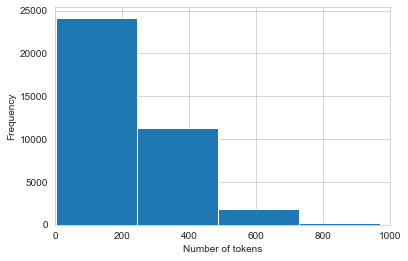

In [41]:
# histogram 

plt.xlim([0,1000])
plt.hist(visualize_len, bins=20)
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")

In [42]:
reduced_df = transform_df.limit(15)

In [43]:
def feature_extraction(df, column_name="terms_stemmed"):   
    
    cv = CountVectorizer(inputCol=column_name, outputCol="count_vectorizer", vocabSize=100, minDF=5)
    tf = IDF(inputCol="count_vectorizer", outputCol="tf_features")
    
    pipeline = Pipeline(stages=[cv,tf])
    features = pipeline.fit(df)
    tf_idf = features.transform(df)
    
    return tf_idf

In [44]:
features_tf_df = feature_extraction(reduced_df)

In [45]:
# show the first 10 columns 

features_tf_df.show(10)

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|label|              tokens|               terms|       terms_stemmed|    count_vectorizer|         tf_features|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|washington reuter...|    0|[washington, reut...|[washington, reut...|[washington, reut...|(43,[1,4,5,6,8,9,...|(43,[1,4,5,6,8,9,...|
|gaza reuters the ...|    0|[gaza, reuters, t...|[gaza, reuters, u...|[gaza, reuter, un...|(43,[0,1,4,7,10,1...|(43,[0,1,4,7,10,1...|
|get to know this ...|    1|[get, to, know, t...|[get, know, woman...|[get, know, woman...|(43,[0,1,2,8,10,1...|(43,[0,1,2,8,10,1...|
|after widespread ...|    1|[after, widesprea...|[widespread, bipa...|[widespread, bipa...|(43,[0,1,2,3,4,6,...|(43,[0,1,2,3,4,6,...|
|if anything more ...|    1|[if, anything, mo...|[anything, gr

In [46]:
# display only the two last changes of the df

features_tf_df.select("count_vectorizer","tf_features").show(n=10)


+--------------------+--------------------+
|    count_vectorizer|         tf_features|
+--------------------+--------------------+
|(43,[1,4,5,6,8,9,...|(43,[1,4,5,6,8,9,...|
|(43,[0,1,4,7,10,1...|(43,[0,1,4,7,10,1...|
|(43,[0,1,2,8,10,1...|(43,[0,1,2,8,10,1...|
|(43,[0,1,2,3,4,6,...|(43,[0,1,2,3,4,6,...|
|(43,[2,3,5,6,11,1...|(43,[2,3,5,6,11,1...|
|(43,[0,1,3,4,5,7,...|(43,[0,1,3,4,5,7,...|
|(43,[1,2,4,5,6,8,...|(43,[1,2,4,5,6,8,...|
|(43,[1,2,3,5,6,7,...|(43,[1,2,3,5,6,7,...|
|(43,[1,4,5,11,19,...|(43,[1,4,5,11,19,...|
|(43,[0,3,6,14,15,...|(43,[0,3,6,14,15,...|
+--------------------+--------------------+
only showing top 10 rows



###  Model Training Phase

In [47]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import BinaryClassificationMetrics


In [48]:
# Splitting the dataset into 2 parts, train and testing 80% and 20% respectively

train_split_df, test_split_df = features_tf_df.randomSplit([0.8,0.2])


In [49]:
test_split_df.count()

2

In [50]:
train_split_df.count()

13

In [51]:
test_split_df.columns

['text',
 'label',
 'tokens',
 'terms',
 'terms_stemmed',
 'count_vectorizer',
 'tf_features']

In [52]:
# to free some space in RAM
import gc

test_split_df = test_split_df.drop("tokens", "terms", "terms_stemmed", "count_vectorizer", "text")

print("Garbage collector: collected %d objects" % (gc.collect()))

Garbage collector: collected 381 objects


In [53]:
train_split_df = train_split_df.drop("tokens", "terms", "terms_stemmed", "count_vectorizer", "text")

print("Garbage collector: collected %d objects" % (gc.collect()))


Garbage collector: collected 26 objects


In [54]:
test_split_df.columns

['label', 'tf_features']

In [55]:
train_split_df.columns

['label', 'tf_features']

### Model  Functions / Automatization

#### Perform Cross-Validation 

In [56]:
def cross_valid(df, estimator, num_folds, param_name, param_values, evaluator):
    
    # ParamMap(s) — the list of parameters we want to evaluate to find the best model

    param_grid = ParamGridBuilder().baseOn({estimator.labelCol: 'label'}).baseOn([estimator.predictionCol, 'prediction'])
    
    for i in range(0, len(param_name)):
        param_grid = param_grid.addGrid(param_name[i], param_values[i])
        
    param_grid = param_grid.build()
    
    cv = CrossValidator(estimator=estimator,
                           estimatorParamMaps=param_grid,
                           evaluator= evaluator,
                           numFolds=num_folds, 
                           parallelism=8)
    
    training_model = cv.fit(df)
                                    
    
    return training_model
    

#### Visualisation of ROC Curve

In [57]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

### Evaluate performance on train/test data - Visualisation
#### Automatization function

In [58]:
from pyspark.mllib.evaluation import MulticlassMetrics

def evaluate_performance(df, model):  
    
    best_model = model.bestModel
    
    # generate predictions
    label_predictions = best_model.transform(df)
    
    # convert from int to double - the method requirement
    label_predictions =  label_predictions.withColumn("label", label_predictions.label.cast('double'))
    label_predictions =  label_predictions.withColumn("prediction", label_predictions.prediction.cast('double'))

    metrics = MulticlassMetrics(label_predictions.select('prediction', 'label').rdd)
    print(metrics.confusionMatrix().toArray())
        
    print("Accuracy for class 1: ", metrics.accuracy)
    print("F1-score for class 0: ", metrics.fMeasure(0.0))
    print("F1-score for class 1: ", metrics.fMeasure(1.0))   
    
    evaluate = BinaryClassificationEvaluator(labelCol="label", metricName='areaUnderROC')
    print("AreaUnderROC: ", evaluate.evaluate(label_predictions))
    
    pred = label_predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
    points = CurveMetrics(pred).get_curve('roc')

    plt.figure()
    x_val = [x[0] for x in points]
    y_val = [x[1] for x in points]
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot(x_val, y_val)


## Logistic Regression

In [78]:
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import MulticlassMetrics

In [146]:
train_split_df.columns

['label', 'tf_features']

In [147]:
# Setup Logistic regression 

log_reg = LogisticRegression(featuresCol="tf_features", labelCol='label')

In [148]:
param_names = [log_reg.regParam, log_reg.maxIter]
param_values = [[0.1, 0.01], [1,4]]

ev = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")
log_reg_cv = cross_valid(df=train_split_df ,estimator=log_reg, num_folds=5, param_name=param_names, param_values=param_values,evaluator=ev)

#### Evaluate performance on Test Set

C:\Users\User\anaconda3\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[[0. 2.]
 [1. 2.]]
Accuracy for class 1:  0.4
F1-score for class 0:  0.0
F1-score for class 1:  0.5714285714285715
AreaUnderROC:  0.6666666666666666


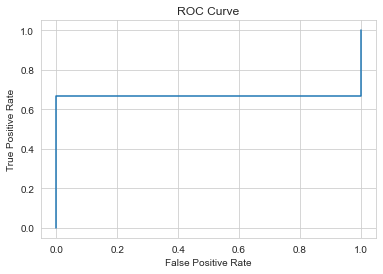

In [149]:
evaluate_performance_lr_testSet = evaluate_performance(df=test_split_df, model=log_reg_cv)


#### Evaluate performance on Train Set

[[4. 0.]
 [0. 6.]]
Accuracy for class 1:  1.0
F1-score for class 0:  1.0
F1-score for class 1:  1.0
AreaUnderROC:  1.0


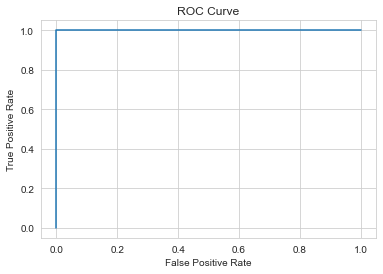

In [150]:
evaluate_performance_lr_trainSet = evaluate_performance(df=train_split_df, model=log_reg_cv)

#### Best tuned Hyper parameters

In [151]:
best_regParam = log_reg_cv.bestModel._java_obj.getRegParam()
best_maxIter = log_reg_cv.bestModel._java_obj.getMaxIter()

In [152]:
print("Best iteration value: ", best_maxIter)
print("Best regularization parameter value: ", best_regParam)

Best iteration value:  1
Best regularization parameter value:  0.1


## Random Forest Classifier

In [153]:
from pyspark.ml.classification import RandomForestClassifier

In [154]:
# Setup Random Forest

rf = RandomForestClassifier(featuresCol="tf_features", labelCol='label')

In [1]:
param_names = [rf.maxDepth, rf.numTrees]
param_values = [[1,3,5,15,20], [10, 21, 28]]

ev = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")
cv_rf = cross_valid(df=train_split_df ,estimator=rf, num_folds=5, param_name=param_names, param_values=param_values,evaluator=ev)

#### Evaluate performance on Test Set

[[1. 1.]
 [2. 1.]]
Accuracy for class 1:  0.4
F1-score for class 0:  0.4
F1-score for class 1:  0.4
AreaUnderROC:  0.5


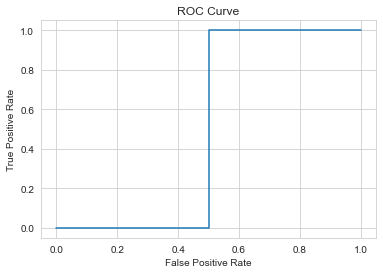

In [157]:
evaluate_performance_rf_testSet = evaluate_performance(df=test_split_df, model=cv_rf)


#### Evaluate performance on Train Set

[[4. 0.]
 [0. 6.]]
Accuracy for class 1:  1.0
F1-score for class 0:  1.0
F1-score for class 1:  1.0
AreaUnderROC:  1.0


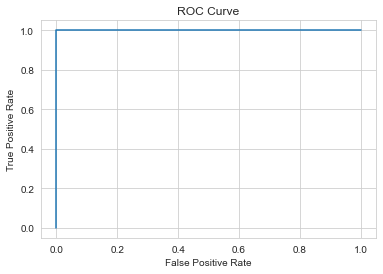

In [158]:
evaluate_performance_rf_trainSet = evaluate_performance(df=train_split_df, model=cv_rf)


#### Best tuned Hyper parameters

In [159]:
best_maxDepth = cv_rf.bestModel._java_obj.getMaxDepth()
best_numTrees = cv_rf.bestModel._java_obj.getNumTrees()

In [160]:
print("Best max depth value: ", best_maxDepth)
print("Best numberof trees : ", best_numTrees)

Best max depth value:  1
Best numberof trees :  10


## Multilayer Perceptron Model

In [59]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

In [60]:
mlp = MultilayerPerceptronClassifier(labelCol="label", predictionCol="prediction", featuresCol="tf_features")

In [61]:
param_names = [mlp.layers, mlp.maxIter, mlp.stepSize]
param_values = [[[43, 5, 2], [43, 2, 2]], [110, 120], [0.01, 0.05, 0.1]]

ev = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")
mlp_cv = cross_valid(df=train_split_df ,estimator=mlp, num_folds=5, param_name=param_names, param_values=param_values,evaluator=ev)

#### Evaluate performance on Test Set

C:\Users\User\anaconda3\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[[1. 0.]
 [0. 1.]]
Accuracy for class 1:  1.0
F1-score for class 0:  1.0
F1-score for class 1:  1.0
AreaUnderROC:  1.0


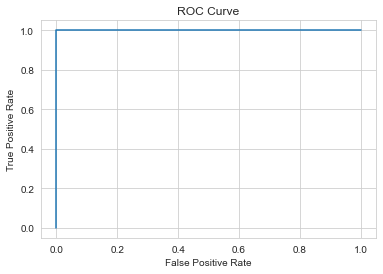

In [62]:
evaluate_performance_mlp_testSet = evaluate_performance(df=test_split_df, model=mlp_cv)

#### Evaluate performance on Train Set

[[5. 0.]
 [0. 8.]]
Accuracy for class 1:  1.0
F1-score for class 0:  1.0
F1-score for class 1:  1.0
AreaUnderROC:  1.0


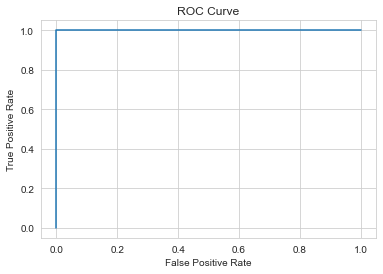

In [63]:
evaluate_performance_mlp_trainSet = evaluate_performance(df=train_split_df, model=mlp_cv)

In [64]:
best_alpha = mlp_cv.bestModel.getStepSize()
best_layer = mlp_cv.bestModel.getLayers()
best_iter =  mlp_cv.bestModel.getMaxIter()

In [65]:
print("Best layer", best_layer)
print("Best learning rate:", best_alpha)
print("Best iteration value: ", best_iter)

Best layer [43, 5, 2]
Best learning rate: 0.01
Best iteration value:  110


## Transformers

In [161]:
from happytransformer import HappyTextClassification, TCTrainArgs


In [162]:
happy_tc = HappyTextClassification(model_type = "BERT", model_name="bert-base-uncased", num_labels=2)


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\User/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-un

#### Split the initial dataframe 'news_df' into train and test

In [163]:
r = news_df.limit(10)
train_split_df, test_split_df = r.randomSplit([0.8,0.2])

#### Create a separate csv file for train and set 

In [164]:
train_toPandas = train_split_df.toPandas()
train_toPandas.to_csv("train.csv", index=False)

In [165]:
test_toPandas = test_split_df.toPandas()
test_toPandas.to_csv("test_eval.csv", index=False)

#### Loss of Train and Test set dataframes before training process

In [166]:
# prediction - label comparison

before_loss_testSet = happy_tc.eval("test_eval.csv").loss
before_loss_trainSet = happy_tc.eval("train.csv").loss

06/04/2022 23:56:52 - INFO - happytransformer.happy_transformer -   Preprocessing dataset...
PyTorch: setting up devices
***** Running Evaluation *****
  Num examples = 4
  Batch size = 1


06/04/2022 23:57:00 - INFO - happytransformer.happy_transformer -   Preprocessing dataset...
PyTorch: setting up devices
***** Running Evaluation *****
  Num examples = 6
  Batch size = 1


In [167]:
print("Loss before testing the test set: ", before_loss_testSet)
print("Loss before training the train set: ", before_loss_trainSet)


Loss before testing the test set:  0.374584436416626
Loss before training the train set:  1.001082420349121


#### Define parameters to train the df

In [168]:
args = TCTrainArgs(num_train_epochs=1, batch_size=16)

#### Fine tuning the model

In [169]:
happy_tc.train("train.csv", args=args)

06/04/2022 23:57:11 - INFO - happytransformer.happy_transformer -   Preprocessing dataset...
PyTorch: setting up devices
C:\Users\User\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




#### Eval - Loss in Train and Test set after training the model
- eval() --> Determines how well the model performs on a labeled dataset / loss in the test set.
- test() --> Runs the model on an unlabeled dataset to produce predictions.
- train() --> Fine-tune the model to become better at a certain task.

In [170]:
after_loss_testSet = happy_tc.eval("test_eval.csv").loss
after_loss_trainSet = happy_tc.eval("train.csv").loss

06/04/2022 23:57:42 - INFO - happytransformer.happy_transformer -   Preprocessing dataset...
PyTorch: setting up devices
***** Running Evaluation *****
  Num examples = 4
  Batch size = 1


06/04/2022 23:57:50 - INFO - happytransformer.happy_transformer -   Preprocessing dataset...
PyTorch: setting up devices
***** Running Evaluation *****
  Num examples = 6
  Batch size = 1


In [171]:
print("Loss after testing the test set: ", after_loss_testSet)
print("Loss after training the train set: ", after_loss_trainSet)

Loss after testing the test set:  0.5877059698104858
Loss after training the train set:  0.6716809272766113


#### Test - running the model on an unlabeled dataset to produce predictions

In [172]:
column_Text = test_split_df.select("text")

In [173]:
c = column_Text.toPandas()
c.to_csv("text.csv", index=False)

In [174]:
result = happy_tc.test("text.csv")

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.10s/it]


In [175]:
for i in c["text"]:
    print(len(i))

2377
432
1543
2001


In [176]:
print(type(result))

<class 'list'>


In [177]:
# probabilities

print(result)

[TextClassificationResult(label='LABEL_0', score=0.5540649890899658), TextClassificationResult(label='LABEL_0', score=0.5520163178443909), TextClassificationResult(label='LABEL_0', score=0.5546985864639282), TextClassificationResult(label='LABEL_0', score=0.561668872833252)]


In [178]:
print(result[0])

TextClassificationResult(label='LABEL_0', score=0.5540649890899658)


In [179]:
print(result[0].label)

LABEL_0
